<a href="https://colab.research.google.com/github/ayuti/project_list/blob/master/25th_nov_west.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [488]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
import plotly.express as px 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')


In [489]:
data= pd.read_excel(r'zone_nsr_aug.xlsx')

data.head(5)


,PSTG. DATE,Zone,Category,NSR
0,2021-04-02,North,HCV,20.014434
1,2021-04-02,North,HCV,25.567178
2,2021-04-02,North,HCV,25.567178
3,2021-04-02,North,HCV,25.833700
4,2021-04-02,North,HCV,25.373057


In [490]:
#pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
#https://medium.com/analytics-vidhya/forecasting-using-facebooks-prophet-library-ce628e76586b

In [491]:
from pandas_profiling import ProfileReport
report = ProfileReport(data ,title="nsr")
report.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

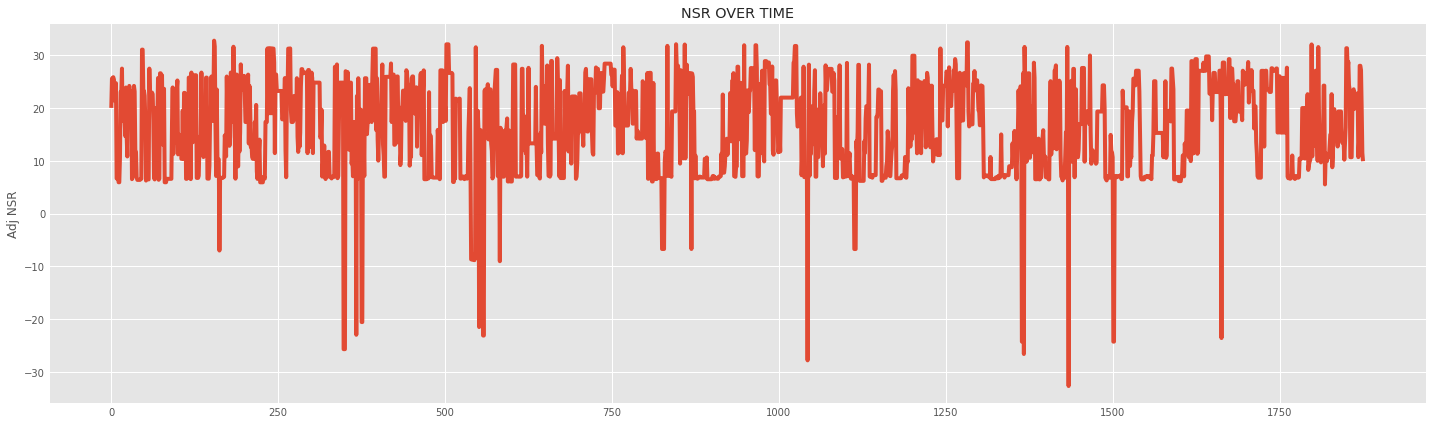

In [492]:
# Let's see a historical view of the closing price

plt.figure(figsize=(20, 6))

data['NSR'].plot()
plt.ylabel('Adj NSR')
plt.xlabel(None)
plt.title(f"NSR OVER TIME")

plt.tight_layout()


In [493]:

#data.drop('index',inplace=True,axis=1)
#data

In [494]:
data["PSTG. DATE"] = pd.to_datetime(data["PSTG. DATE"], infer_datetime_format=True)


In [495]:
data['Category'] = data['Category'].astype('string')
data['Zone'] = data['Zone'].astype('string')

data['NSR'] = data['NSR'].astype(int)

data.dtypes


PSTG. DATE    datetime64[ns]
Zone                  string
Category              string
NSR                    int64
dtype: object

In [496]:
zone_df=data.set_index('PSTG. DATE').groupby('Zone').resample('D').sum()
zone_df.tail(5)


NSR
Zone PSTG. DATE      
West 2021-08-27   249
     2021-08-28   286
     2021-08-29     0
     2021-08-30   190
     2021-08-31  1507

In [497]:
West_df=zone_df.query('Zone=="West"')[['NSR']]
West_df


NSR
Zone PSTG. DATE      
West 2021-04-05   166
     2021-04-06     0
     2021-04-07    11
     2021-04-08    58
     2021-04-09     0
...               ...
     2021-08-27   249
     2021-08-28   286
     2021-08-29     0
     2021-08-30   190
     2021-08-31  1507

[149 rows x 1 columns]

In [498]:
from fbprophet import Prophet
import plotly.graph_objects as go
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from plotly.offline import iplot, init_notebook_mode
from fbprophet.plot import plot_plotly


In [499]:

West_df.reset_index(inplace=True)


In [500]:
prophet_df = West_df.iloc[:,[1,2]]
prophet_df.head()


,PSTG. DATE,NSR
0,2021-04-05,166
1,2021-04-06,0
2,2021-04-07,11
3,2021-04-08,58
4,2021-04-09,0


In [501]:
prophet_df.set_index('PSTG. DATE')

,NSR
PSTG. DATE,
2021-04-05,166
2021-04-06,0
2021-04-07,11
2021-04-08,58
2021-04-09,0
...,...
2021-08-27,249
2021-08-28,286
2021-08-29,0


In [502]:
df = prophet_df.reset_index()
df.drop('index',inplace=True,axis=1)
df = df[(df['NSR'] > 0) ]


In [503]:
"""test_index=20
train=df.iloc[:-test_index]
test=df.iloc[-test_index:]

print(len(train),len(test))"""

'test_index=20\ntrain=df.iloc[:-test_index]\ntest=df.iloc[-test_index:]\n\nprint(len(train),len(test))'

In [504]:
df=df.rename(columns={'PSTG. DATE':'ds', 'NSR':'y'})
df['y_orig'] = df['y'] # to save a copy of the original data.
df['y'] = np.log(df['y'])


In [505]:
df.head()


,ds,y,y_orig
0,2021-04-05,5.111988,166
2,2021-04-07,2.397895,11
3,2021-04-08,4.060443,58
5,2021-04-10,4.007333,55
7,2021-04-12,2.639057,14


In [506]:
model = Prophet() #instantiate Prophet
model.fit(df)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [507]:
''' 'year': 'A',
        'quarter': 'Q',
        'month': 'M',
        'day': 'D',
        'hour': 'H',
        'minute': 'T',
        'second': 'S',
        'millisecond': 'L',
        'microsecond': 'U',
        'nanosecond': 'N'}
'''


future_data = model.make_future_dataframe(periods=30, freq = 'D')

forecast_data = model.predict(future_data)
  
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)


,ds,yhat,yhat_lower,yhat_upper
108,2021-09-26,3.212722,1.730536,4.770803
109,2021-09-27,3.823772,2.220540,5.350589
110,2021-09-28,4.605329,3.162333,6.242465
111,2021-09-29,4.313599,2.587242,5.879333
112,2021-09-30,4.376141,2.861044,5.883069


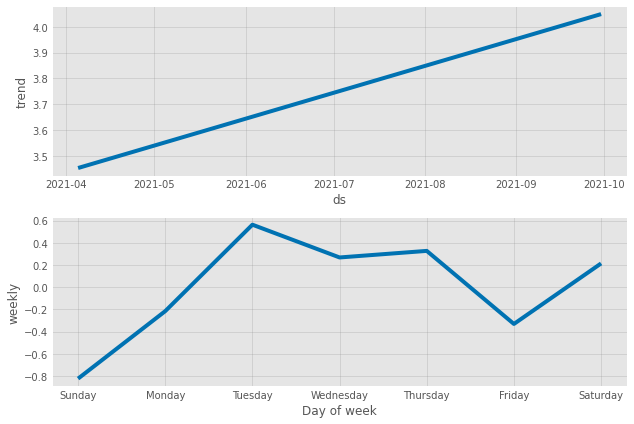

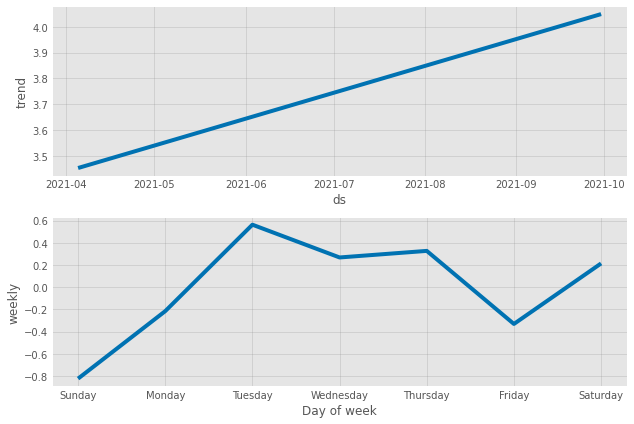

In [508]:
model.plot_components(forecast_data)


In [509]:
forecast_data_orig = forecast_data # make sure we save the original forecast data
forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])


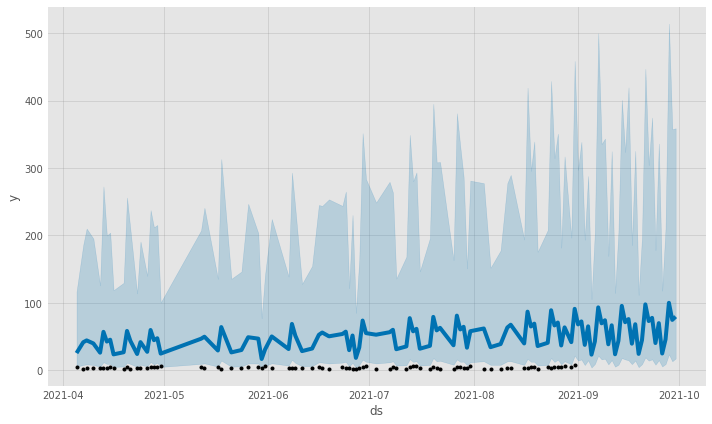

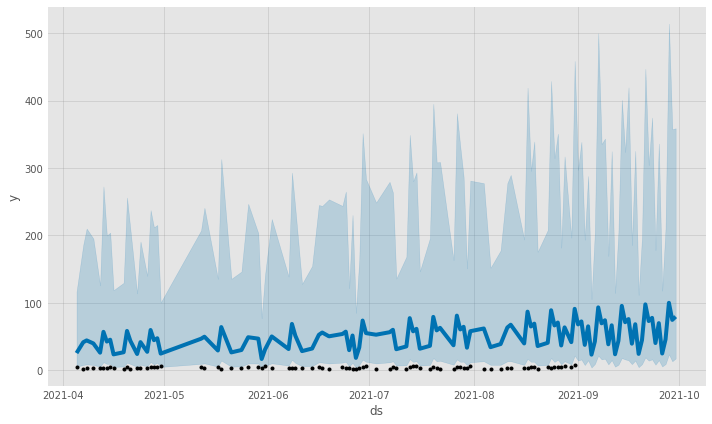

In [510]:
model.plot(forecast_data_orig)


In [511]:
df['y_log']=df['y'] #copy the log-transformed data to another column
df['y']=df['y_orig']


In [512]:
final_df = pd.DataFrame(forecast_data_orig)
import plotly.graph_objs as go
import plotly.offline as py
#Plot predicted and actual line graph with X=dates, Y=Outbound
actual_chart = go.Scatter(y=df["y_orig"], name= 'Actual')
predict_chart = go.Scatter(y=final_df["yhat"], name= 'Predicted')
predict_chart_upper = go.Scatter(y=final_df["yhat_upper"], name= 'Predicted Upper')
predict_chart_lower = go.Scatter(y=final_df["yhat_lower"], name= 'Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])


'temp-plot.html'

In [513]:
rows = final_df["yhat"].tail(30)


In [514]:
rows = rows.reset_index()


In [515]:
rows.pop('index')


0      83
1      84
2      85
3      86
4      87
5      88
6      89
7      90
8      91
9      92
10     93
11     94
12     95
13     96
14     97
15     98
16     99
17    100
18    101
19    102
20    103
21    104
22    105
23    106
24    107
25    108
26    109
27    110
28    111
29    112
Name: index, dtype: int64

KeyError: ignored

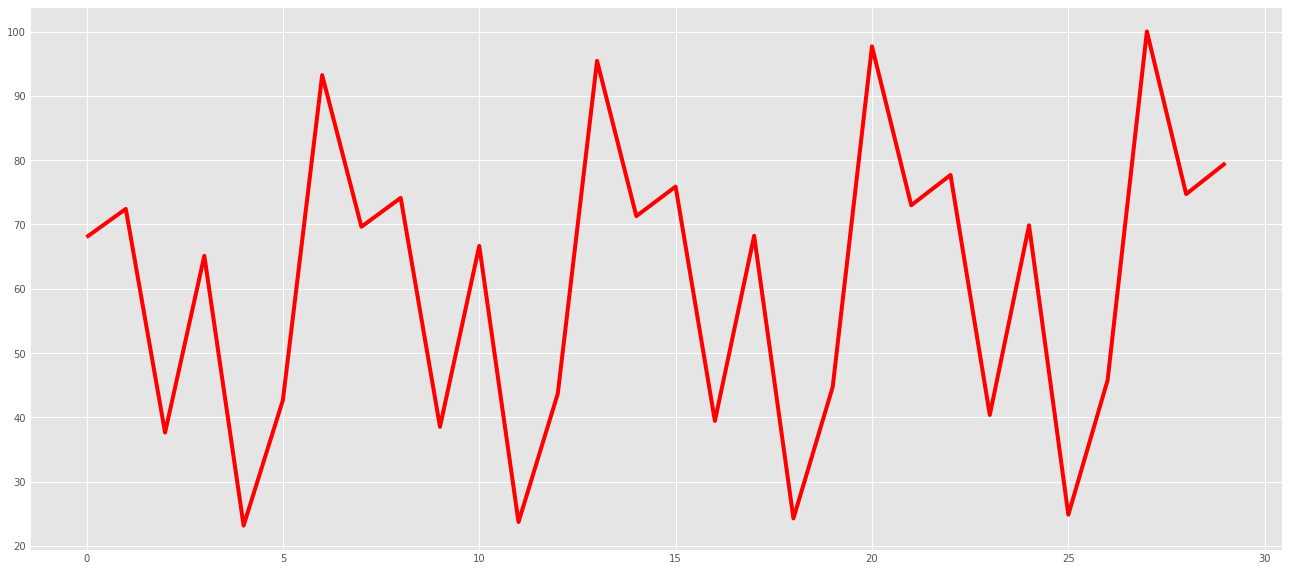

In [516]:
import matplotlib.pyplot as plt
plt.plot(rows, color='red')
plt.plot(df['NSR'], color = 'blue')   

plt.show()


In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast_data_orig)
a = add_changepoints_to_plot(fig.gca(), model, forecast_data_orig)